# TP 6 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import cv2
from sklearn.model_selection import train_test_split

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [40]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 9.],
       [0., 0., 0., ..., 0., 0., 9.],
       [0., 0., 0., ..., 0., 0., 9.]])

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [41]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [42]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

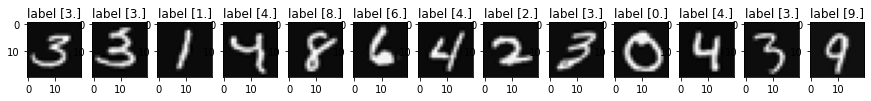

In [43]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [44]:

YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape

(5000, 10)

In [45]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1
YY

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [46]:
# poids de la couche 1
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [47]:
# poids de la couche 2
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [48]:
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [49]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))

In [50]:
def computeCost(X, YY, theta1, theta2,hidden_layer_size):
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    #calculate predictions
    J=-np.sum(np.sum(YY*np.log(a3)+(1-YY)*np.log(1-a3)))/X.shape[0]

    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{i,j)}^{(l)}$


In [121]:
def Gradient(X, YY, theta1, theta2,hidden_layer_size):
    global costs
    J=computeCost(X,YY,theta1,theta2,hidden_layer_size)
    costs.append(J)

    #couche entree
    a1=X.T
    m =np.size(X, 0)
 
    #calcul de la couche 2 (forward propagation)
    z2 = np.dot(theta1 , a1)
    a2 =Sigmoid(z2)
    a2=np.vstack([np.ones((1,m)),a2])

    #calcul de la couche sortante (forward propagation)
    a3 = Sigmoid(np.dot(theta2 , a2)) 

    #calcul des delta
    delta3 = a3 - YY.T 

    delta2 = (np.dot(theta2.T , delta3)) * a2*(1-a2)


    theta1_grad = np.zeros((theta1.shape[0],theta1.shape[1]))
    theta2_grad = np.zeros((theta2.shape[0],theta2.shape[1]))
    theta2_grad += (1/m) * np.dot( delta3 , a2.T)
    theta1_grad += (1/m) * np.dot(delta2[1:, :], a1.T)
    return theta1_grad, theta2_grad


# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [122]:
def gradientDescent(X, YY, theta1, theta2, alpha, iterations):
    for i in range(iterations):
        theta1_grad, theta2_grad=Gradient(X,YY,theta1, theta2,hidden_layer_size)
        theta1 -= alpha*theta1_grad
        theta2 -= alpha*theta2_grad
    return theta1,theta2

Loss :  0.04077197565576316


Text(0, 0.5, 'Loss')

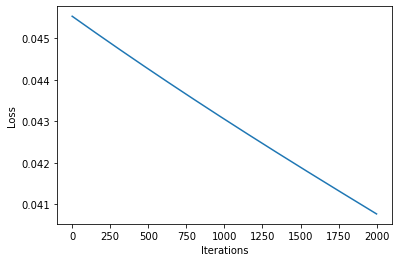

In [123]:
#plot
iterations=2000
alpha=0.5
costs=[]
theta1,theta2=gradientDescent(X,YY,W1,W2,alpha,iterations)
print('Loss : ',costs[-1])
plt.plot(costs)
plt.xlabel('Iterations')
plt.ylabel('Cout')

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [124]:
def computeCostRegularized(X, YY, theta1, theta2,hidden_layer_size, lambda_):
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1))))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3))))) + (lambda_ / (2*y.shape[0])) * ((np.sum(np.sum(theta1[:, 1:] ** 2)) + np.sum(np.sum(theta2[:, 1:] ** 2))))
    return J

In [156]:
def gradientRegularized(X, YY, theta1, theta2,hidden_layer_size, lambda_):
    global costs
    theta1_grad = np.zeros((theta1.shape[0],theta1.shape[1]))
    theta2_grad = np.zeros((theta2.shape[0],theta2.shape[1]))

    m =np.size(X, 0)
    J=computeCostRegularized(X,YY,theta1,theta2,hidden_layer_size,lambda_)
    costs.append(J)

    a1=X.T

    z2 = np.dot(theta1 , a1)
    a2 =np.vstack([np.ones((1, m)), Sigmoid(z2)])

    a3 = Sigmoid(np.dot(theta2 , a2))  
    d3 = a3 - YY.T 

    d2 = (np.dot(theta2.T , d3)) * a2*(1-a2)

    theta2_grad += (1/m) * np.dot( d3 , a2.T)
    theta1_grad += (1/m) * np.dot(d2[1:, :], a1.T)
    theta2_grad += (lambda_ / m) * theta2
    theta1_grad += (lambda_ / m) *theta1
    return theta1_grad, theta2_grad

In [157]:
def gradientDescentRegularized(X, YY, theta1, theta2, alpha, iterations, lambda_):
    for i in range(iterations):
        theta1_grad, theta2_grad=gradientRegularized(X,YY,theta1, theta2,hidden_layer_size,lambda_)
        theta1 -= alpha*theta1_grad
        theta2 -= alpha*theta2_grad
    return theta1,theta2

Loss :  0.03361781932910709


Text(0, 0.5, 'Loss')

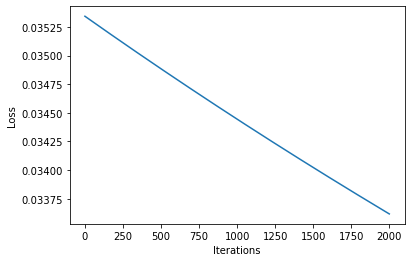

In [158]:
#plot
iterations=2000
alpha=0.5
lambda_=0.012
costs=[]
theta1,theta2=gradientDescentRegularized(X,YY,W1,W2,alpha,iterations, lambda_)
print('Loss : ',costs[-1])
plt.plot(costs)
plt.xlabel('Iterations')
plt.ylabel('Loss')

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [159]:
def predict (theta1, theta2, X): 
    #avec regularisation
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie

    #feed forward
    a1=X; 

    z2= np.zeros((X.shape[0],hidden_layer_size))

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,theta1.T)))
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    

    z3=np.matmul(a2,theta2.T)
    a3=Sigmoid(z3)
    y_pred=np.argmax(a3)
    y_pred=y_pred.reshape(y_pred.shape[0],1)

    return y_pred

In [160]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(theta1,theta2,X)
precision = np.mean(y==y_pred)*100
precision

99.94

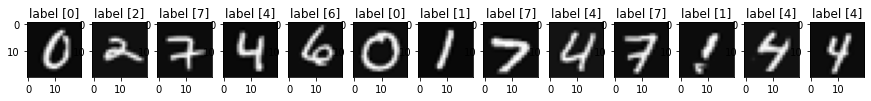

In [161]:
plt.figure(figsize=(15, 8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c, 1:].reshape((20, 20))
    a = np.transpose(a)
    plt.subplot(1, 13, i+1)
    plt.title('label ' + str(y_pred[c]))
    plt.imshow(a, cmap='gray')

# optionnel 1 : Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

# Optionnel 2 : Visualisation des poids
    
La visualisation de poids permet de voir quel partie du réseau est activé et pour quelle classe.
Il est possible de visulaiser les paramètres theta1 . 
Ceci peut se faire en utilisant un reshape de ces paramètres afin d'avoir 25 images de taille 20x20 (n'oubliez pas d'ignorer la premuère colonne, celle du biais)

# Optionnel 3 : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage

# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le vendredi 29Avril 2022 à 22h


In [162]:
# bonne chance